In [1]:
%matplotlib notebook 

import numpy as np
import os.path as op
import glob as glob
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

# Plot LRS2 spec class

This class will extract your spectra for the channels you give it data for and plot a spectrum.

**Define your lsr2_spec object:**

1. The parameters `files_uv, files_or, files_re, files_fr` need to be given files lists of the spectrum files for 
   the uv, orange, red, and farred channels respectively. 
2. If you don't have data for a channel or dont want it plotted just put 'None' in for that channel's file. 
3. Default `scale`=1e16: This will scale the spectra values up by that factor 

**build_spec options:**

1. Default `combine`=False: if True will build a median spectra of the list of spectrum files for each channel. 
2. Defult `save_combine`=False: if True and combine=True it will save the combined spectrum to a fits file 
3. Default `smooth`=False: if True will smooth the spectra based on the conv_dict parameter. 
    you can give conv_dict a dictionary of the smoothing kernal size for each channel (only need channels used)

**plot_obj options:**

1. you must give the function the ax of your plot. This helps in building subplots of mulitple objects
2. Default `z`=None: You can set the redshift of the object and then it will plot emission line
3. Default `title`=None: This will change the title of the plot to the object name given
4. Default `save`=None: If you give save a path and filename.png it will save the plot to an output file. 


In [2]:
class lrs2_spec():
    def __init__(self, files_uv, files_or, files_re, files_fr, scale=1e16): 
        
        self.chan_dict = {'uv':{'files':files_uv, 'wave':[], 'spec': [], 'c':0}, 
                          'or':{'files':files_or, 'wave':[], 'spec': [], 'c':1},
                          're':{'files':files_re, 'wave':[], 'spec': [], 'c':3},
                          'fr':{'files':files_fr, 'wave':[], 'spec': [], 'c':5}}
        
        self.scale     = scale
        self.conv_dict = {'uv':1.0, 'or':1.0, 're':1.0, 'fr':1.0}
        self.max_spec = []
        
    def build_spec(self, combine=False, save_combine=True, smooth=False, conv_dict=None):
        for chan in self.chan_dict:
            f = self.chan_dict[chan]['files']
            #will only build a channel spectrum if there is a filelist
            if f != None:
                #will combine if that option is True and there is multiple files in list 
                if (combine == True) and (len(f) > 1):
                    s_lis   = []
                    sn_lis  = []
                    w_lis   = []
                    e_lis   = []
                    sk_lis  = []
                    ske_lis = []
                    et_lis  = []
                    #extracts each spectrum and wavelength solution and appends to list
                    for i in range(len(f)):
                        dat, hdr = fits.getdata(f[i], 0, header=True)
                        w = dat[0,:]
                        s = dat[1,:]*self.scale
                        sn = dat[1,:]
                        sk = dat[2,:]
                        e = dat[3,:]
                        ske = dat[4,:]
                        et = hdr['REXPTIME']
                        w_lis.append(w)
                        s_lis.append(s)
                        sn_lis.append(sn)
                        e_lis.append(e)
                        sk_lis.append(sk)
                        ske_lis.append(ske)
                        et_lis.append(et)
                
                    #stacks all wavelength solutions for a channel in array
                    w_stack = np.vstack(w_lis)
                    #checks that each spec has same wavelength solution
                    if np.isclose(w_stack, w_stack[0]).all():
                        self.chan_dict[chan]['wave'] = w_lis[0]
                    else:
                        print('Different wl solutions')
                        
                    #build the weights based on exposure time
                    et_lis = np.divide(et_lis, float(np.amax(et_lis)))
                    
                    #stacks all spectra and takes median of the stack
                    s_stack = np.vstack(s_lis)
                    stack_spec = np.average(s_stack, axis=0, weights=et_lis)
                    
                    #save the files to a fits file if a save path is given 
                    if save_combine:
                        sn_stack = np.vstack(sn_lis)
                        stack_spec_norm = np.average(sn_stack, axis=0, weights=et_lis)
                        
                        sk_stack = np.vstack(sk_lis)
                        stack_sky = np.average(sk_stack, axis=0, weights=et_lis)
                        
                        e_stack = np.vstack(e_lis)
                        stack_e = np.sqrt(np.sum(((e_stack**2).T*et_lis).T, axis=0))/4.
                        
                        ske_stack = np.vstack(ske_lis)
                        stack_ske = np.sqrt(np.sum(((ske_stack**2).T*et_lis).T, axis=0))/4.

                        data_stack = np.vstack((w_lis[0], stack_spec_norm, stack_sky, stack_e, stack_ske))
                        fits.writeto(op.join(f[0].split('.')[0]+'_combine.fits'), data_stack, hdr, overwrite=True)
                    
                    #if smooth options choosen will use Gaussian kernal to smooth spectrum 
                    if smooth:
                        #will use default std dict for convolution of none given
                        #the default contains all 1.0 so no smoothing will occur 
                        if conv_dict==None:
                            conv_dict = self.conv_dict
                        conv_std = conv_dict[chan]
                        gauss_kernel = Gaussian1DKernel(conv_std)
                        self.chan_dict[chan]['spec'] = convolve(stack_spec*self.scale, gauss_kernel)
                    else:    
                        self.chan_dict[chan]['spec'] = stack_spec*self.scale
                
                #If combine is False or there is only one spectrum in channel just extract first file
                else:
                    dat, hdr = fits.getdata(f[0], 0, header=True)
                    self.chan_dict[chan]['wave'] = dat[0,:]
                    
                    if smooth:
                        if conv_dict==None:
                            conv_dict = self.conv_dict
                        conv_std = conv_dict[chan]
                        gauss_kernel = Gaussian1DKernel(conv_std)
                        self.chan_dict[chan]['spec'] = convolve(dat[1,:]*self.scale, gauss_kernel)
                    else:
                        self.chan_dict[chan]['spec'] = dat[1,:]*self.scale
                        
                #will find max of each spectrum for plot scaling 
                self.max_spec.append(np.amax(self.chan_dict[chan]['spec']))
                print(chan+': spectrum found')
                                                            
            else:
                print(chan+': NO FILE')
                self.chan_dict[chan]['files'] = None

                    
            
    def plot_obj(self, ax, z=None, title=None, save=None):
        
        cp = sns.color_palette()
        
        #list of strong lines (in angstroms) to plot if redshift given 
        strong_lines = [3727, 3869, 4861, 4959, 5007, 6300, 6562, 6549, 6583, 6717, 6731]
        y_vals = np.linspace(-1, np.amax(self.max_spec)*10, 50)
        
        for chan in self.chan_dict:
            if self.chan_dict[chan]['files'] != None:
                w = self.chan_dict[chan]['wave']
                s = self.chan_dict[chan]['spec']
                #plot the spectrum in the color index defined in chan_dict
                ax.plot(w, s, color=cp[self.chan_dict[chan]['c']])
                
                #mark the 5577 sky line in the orange channel
                if chan=='or':
                    ax.fill_betweenx(y_vals, np.zeros(50)+5564, np.zeros(50)+5592, color=cp[7], alpha=0.4, zorder=1000)

                #if a redshift is given plot markers for emission lines
                if z != None:
                    wave_range = (np.amin(w), np.amax(w))
                    for s in strong_lines:
                        #checks what strong lines are in the given channel 
                        s = s*(1.0+float(z))
                        if (wave_range[0] < s) and (s < wave_range[1]):
                            ax.plot(np.zeros(50)+s, y_vals, color=cp[7], ls=':')

        ax.set_ylim(-0.5, np.amax(self.max_spec)*1.5)
        ax.set_xlabel(r'$Wavelength\ \AA$', fontsize=20, weight='bold')
        ax.set_ylabel(r'$Flux\ (ergs/s/cm^2/\AA)$ x('+str(1/self.scale)+')', fontsize=20)
        
        if title != None:
            if z != None:
                ax.set_title(title + ' (z='+str(z)+')', fontsize=25, weight='bold')
            else:
                ax.set_title(title, fontsize=25, weight='bold')

        if save != None:
            plt.savefig(save)

        plt.show()          
            

# Build your object

## Define object properties 

Here you can define the name and the redshift of the object you observed

In [3]:
#define the object name 
hps_obj = 'HPS100021+021351' 
#hps_obj = 'HPS123652+621125'

#define the redshift 
hps = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/HPS_all_props.csv')
hps_z = hps.loc[hps['HPS_name'] == hps_obj].z.values[0]

## Load in data 

Here you want to define a list of spectrum files for each of the channels you have data for

In [40]:
datapath = '/Users/Briana/Documents/Grad_School/HPS/LRS2_reductions/OIII_objects/*/lrs2/lrs2*/exp*/lrs2/'
#datapath = '/Volumes/Briana_mac3/HPS/LRS2_reduction_greg/reductions4/HET19-1-202/new/'

if hps_obj == 'HPS100021+021351':
    date = '20190126' #'20190202'
    blu_obs = '0000023' #'0000016'
    red_obs = '0000024' #'0000017'
elif hps_obj == 'HPS123652+621125':
    date = '20190202'
    blu_obs = '0000016'
    red_obs = '0000017'

files_uv = glob.glob(datapath+'spectrum_'+date+'_'+blu_obs+'_exp01_uv.fits')
files_or = glob.glob(datapath+'spectrum_'+date+'_'+blu_obs+'_exp01_orange.fits')
files_re = glob.glob(datapath+'spectrum_'+date+'_'+red_obs+'_exp01_red.fits')
files_fr = glob.glob(datapath+'spectrum_'+date+'_'+red_obs+'_exp01_farred.fits')

print 'uv:', len(files_uv), 'or:', len(files_or), 're:', len(files_re), 'fr:', len(files_fr)

uv: 1 or: 1 re: 1 fr: 1


In [41]:
# datapath_new = '/Users/Briana/Documents/Grad_School/HPS/LRS2_reductions/OIII_objects/20190316/redo_1/'
# files_re_new = glob.glob(datapath_new+'spectrum_*_red.fits')
# files_re_old = glob.glob(datapath+'spectrum_20190202_0000017_exp01_red.fits')
# files_re = files_re_new + files_re_old
# print files_re

## Call lrs2_spec class

In [42]:
#Define your oject 
hps_spec = lrs2_spec(files_uv, files_or, files_re, None, scale=1e16)

#Build your object spectrum 
hps_spec.build_spec(combine=True, save_combine=False, smooth=True, conv_dict = {'uv':4.0, 'or':3.0, 're':2.0, 'fr':1.0})

re: spectrum found
fr: NO FILE
uv: spectrum found
or: spectrum found


<IPython.core.display.Javascript object>


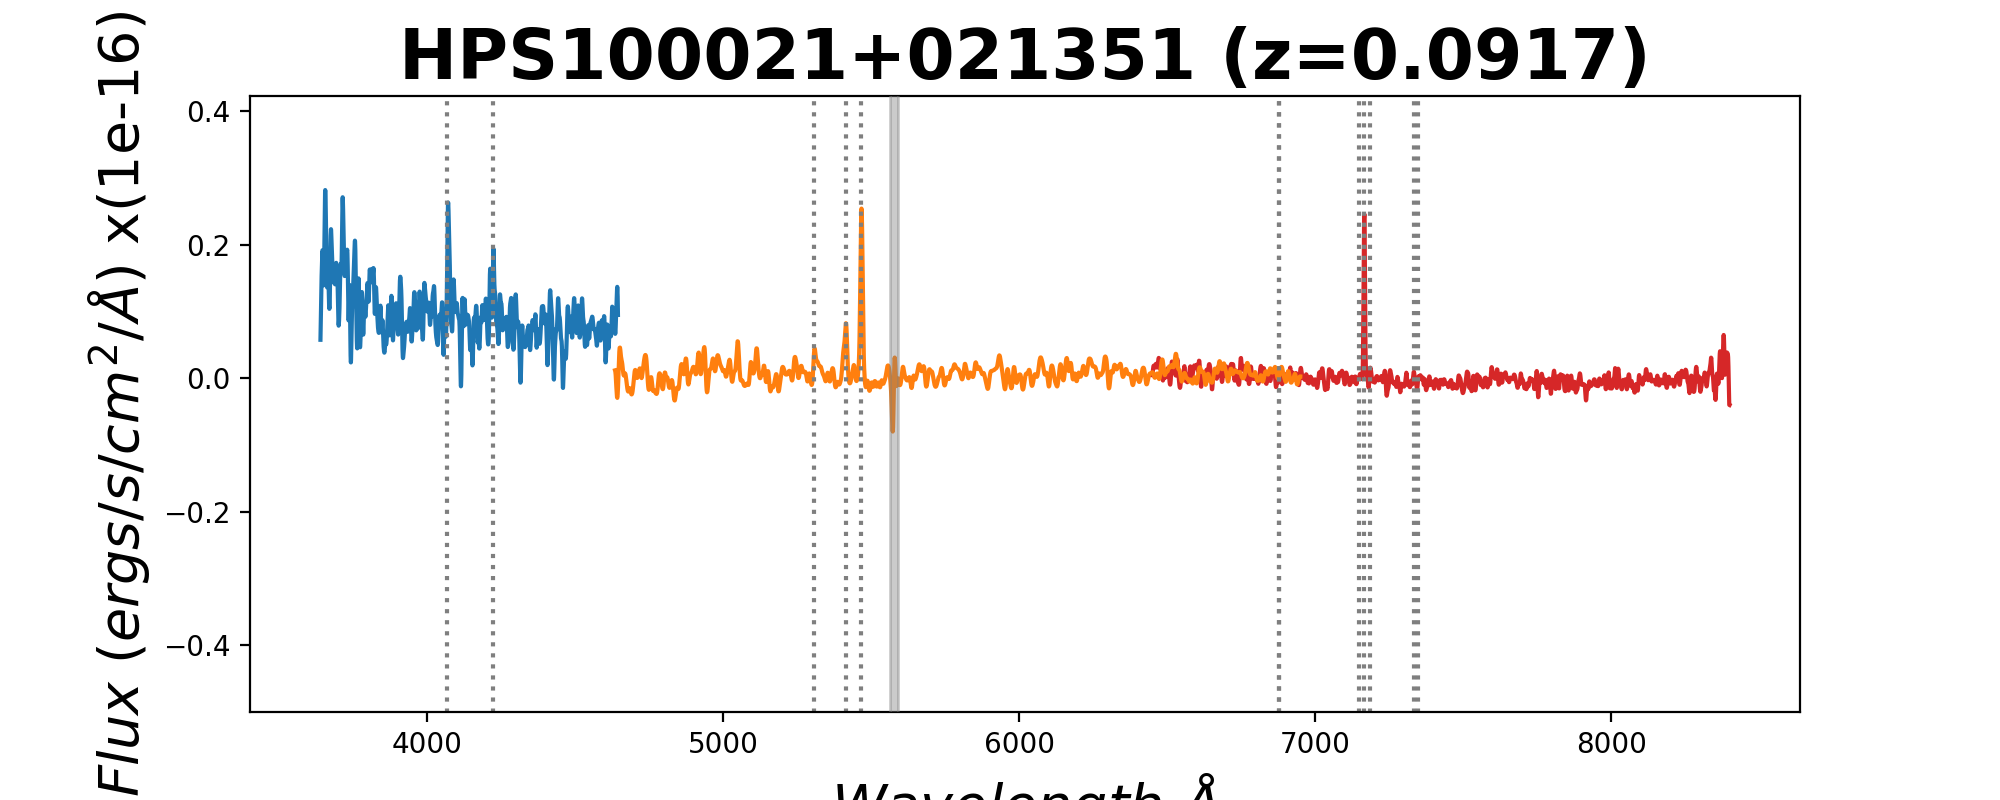

In [43]:
#Define your figure 
fig, ax = plt.subplots(figsize=(10,4))
#deine the path to save the plots
plot_path = '/Users/Briana/Documents/Grad_School/HPS/Paper_Plots'

#Plot your spectrum and save it
hps_spec.plot_obj(ax, title=hps_obj, z=hps_z, save=plot_path+'/'+hps_obj+'_fullspec.png')